# Testing notebook for nifty fit on atmosphere TODs directly (no image)

# Try to add a nifty model for sampling the input map

numpy version: 2.1.1


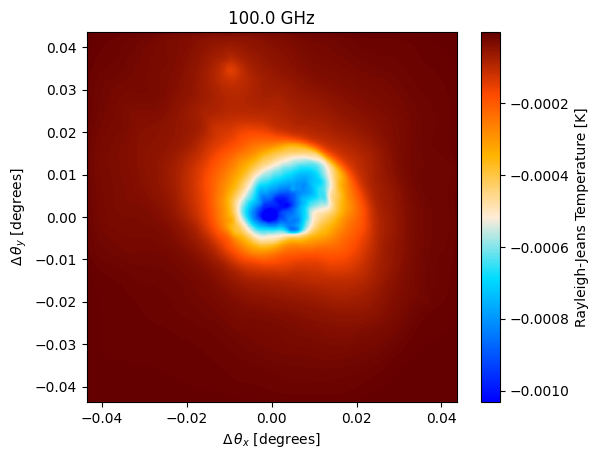

In [1]:
import numpy as np
print(f"numpy version: {np.__version__}")
import matplotlib.pyplot as plt
import maria
import sys
import os

# Relative import of sample_maps for now
sys.path.append(os.path.abspath('../python'))
import mapsampling_jax
from mapsampling_jax import sample_maps

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

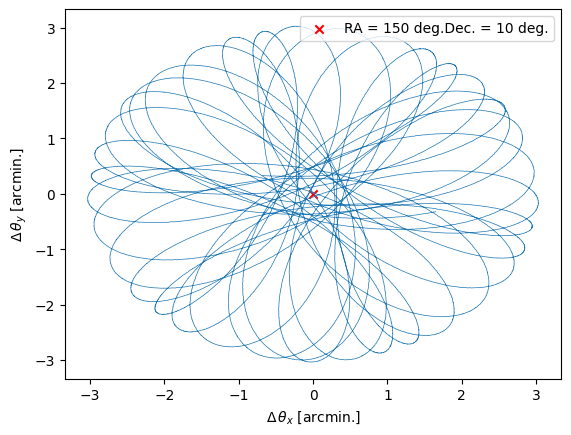

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                    # duration=60,
                    #   duration=300, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

2024-10-18 09:36:31.430 INFO: Initialized base in 1554 ms.
Building atmosphere: 100%|██████████| 6/6 [00:03<00:00,  1.56it/s]
2024-10-18 09:36:36.603 INFO: Initialized atmosphere in 5159 ms.
Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


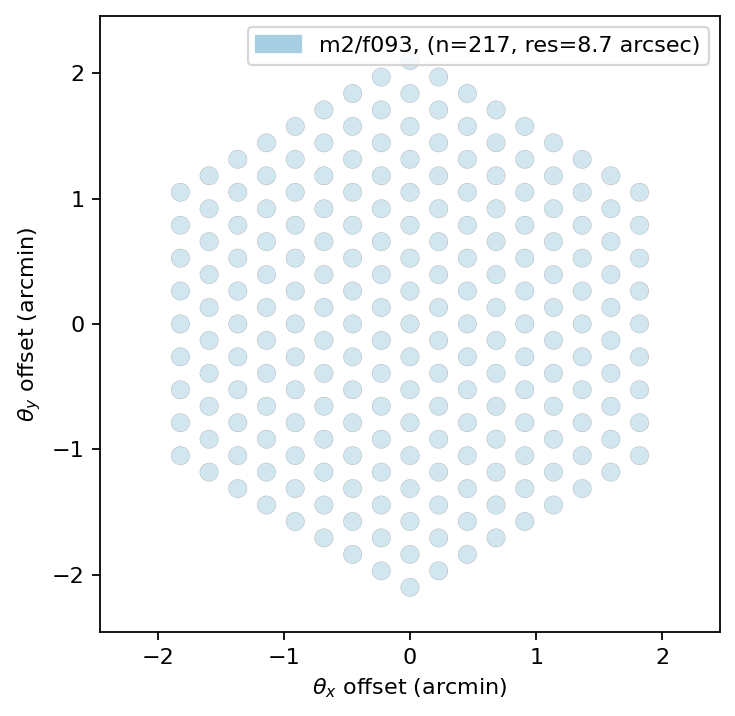

In [3]:
# instrument = maria.get_instrument('MUSTANG-2')
instrument = mapsampling_jax.instrument
instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

dx

array([[-1.96753810e-04, -1.94025956e-04, -1.89786259e-04, ...,
         4.73017578e-04,  4.77688814e-04,  4.79782756e-04],
       [-2.45872898e-04, -2.43145117e-04, -2.38905620e-04, ...,
         4.27671010e-04,  4.32341945e-04,  4.34435842e-04],
       [-1.21563619e-04, -1.18835782e-04, -1.14596131e-04, ...,
         5.48895584e-04,  5.53566778e-04,  5.55660714e-04],
       ...,
       [ 1.21008725e-04,  1.23737177e-04,  1.27978517e-04, ...,
         7.59912062e-04,  7.64585753e-04,  7.66680061e-04],
       [-4.05322614e-04, -4.02594047e-04, -3.98352389e-04, ...,
         2.28766012e-04,  2.33439996e-04,  2.35534348e-04],
       [-7.46133143e-04, -7.43405335e-04, -7.39165765e-04, ...,
        -7.29436098e-05, -6.82727245e-05, -6.61788346e-05]])

Running mapper (m2/f093): 100%|██████████| 1/1 [00:05<00:00,  5.65s/it]


mapdata_truth shape: (1, 1000, 1000)
mapdata_truth mean: -8.726028151723567e-05


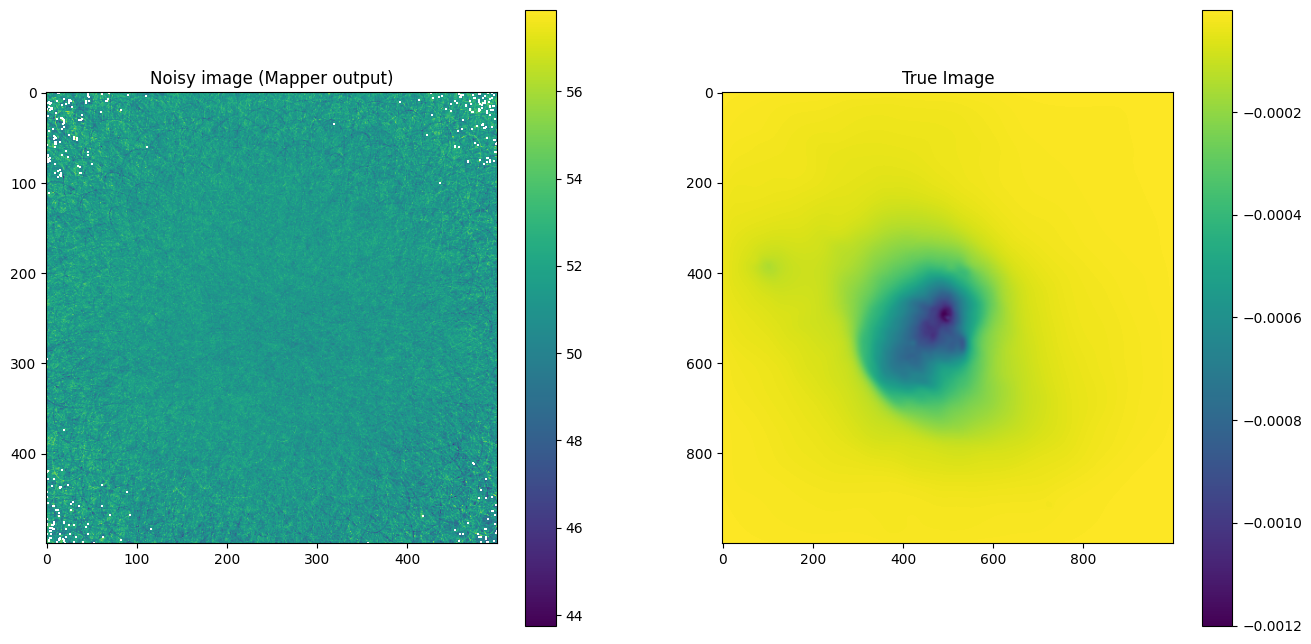

In [5]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0].T)
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
from jax import random
import jax.numpy as jnp

import nifty8.re as jft
import matplotlib.pyplot as plt

import numpy as np

from functools import reduce
from operator import or_

seed = 42
key = random.PRNGKey(seed)

2024-10-18 09:36:50.980 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-10-18 09:36:50.982 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Test TOD agreement:

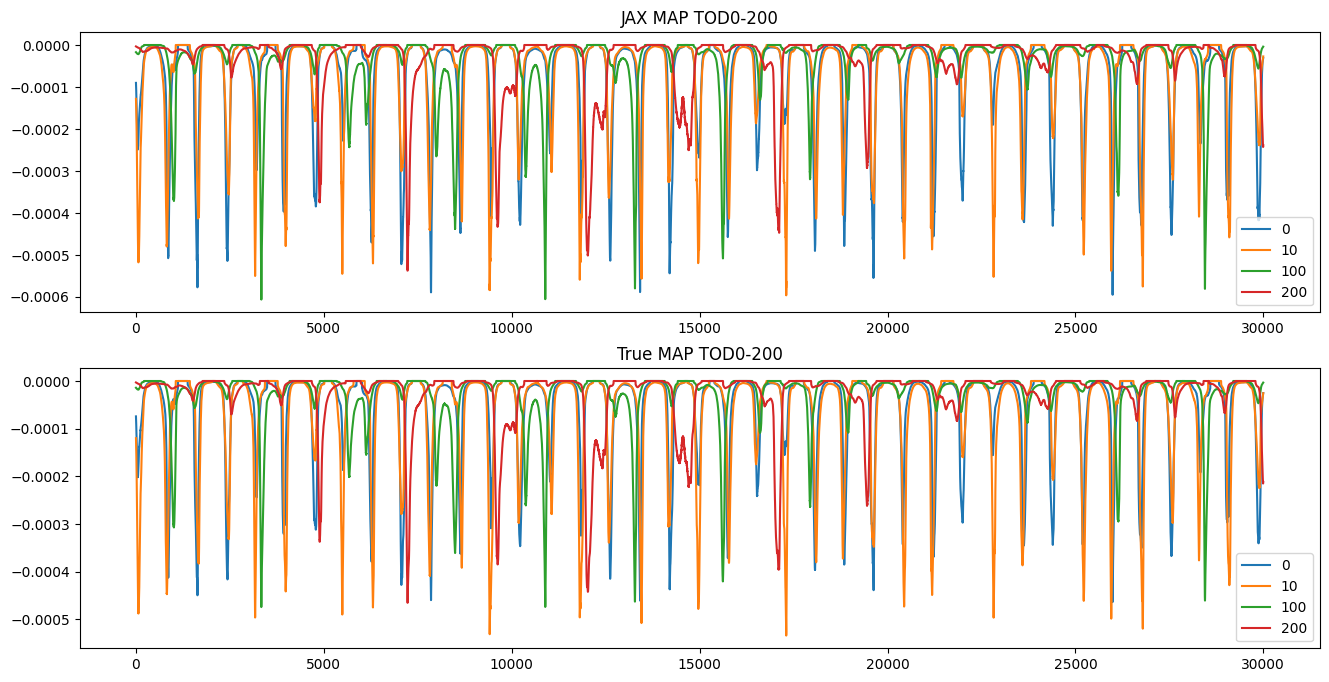

In [7]:
jax_tods_map = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods_map[i], label=i)

    tods_map = np.float64(tod_truthmap.get_field('map').compute())
    im1 = axes[1].plot(tods_map[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True MAP TOD0-{i}')
axes[1].legend()

plt.show()

# Prepare noised input TODs:

Noise stddev: 0.0002519907998669714


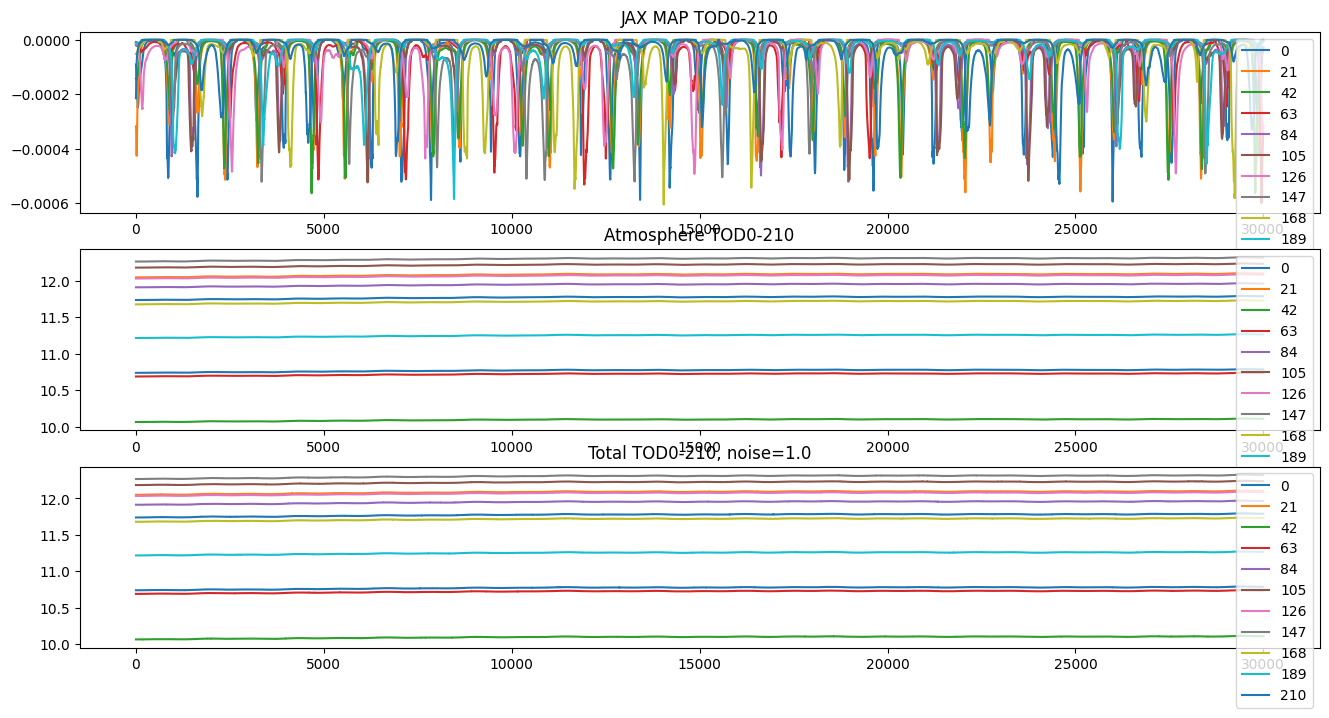

In [8]:
# Pick noise level for rest of run:
# noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
noiselevel = 1.0

# Add n TODs for atmos:
# n = 1
# n = 10
# n = 100
n = jax_tods_map.shape[0]

jax_tods_atmos = tod_truthmap.get_field('atmosphere')
# noised_jax_tod = np.float64(jax_tods_map) + np.float64(jax_tods_atmos) + np.float64(tod_truthmap.components['noise']*noiselevel)

noised_jax_tod = np.float64(jax_tods_map) + np.float64(tod_truthmap.get_field('noise')*noiselevel)
noised_jax_tod[:n] += np.float64(jax_tods_atmos[:n]) 
# # noised_jax_tod[:n] = np.float64(jax_tods_atmos[:n])

denoised_jax_tod = noised_jax_tod - np.float64(tod_truthmap.get_field('noise')*noiselevel)

print("Noise stddev:", np.std(tod_truthmap.get_field('noise').compute()))

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in range(0, n, n//10):
    im0 = axes[0].plot(jax_tods_map[i], label=i)
    im1 = axes[1].plot(jax_tods_atmos[i], label=i)
    im2 = axes[2].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'Atmosphere TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'Total TOD0-{i}, noise={noiselevel}')
axes[2].legend()

plt.show()

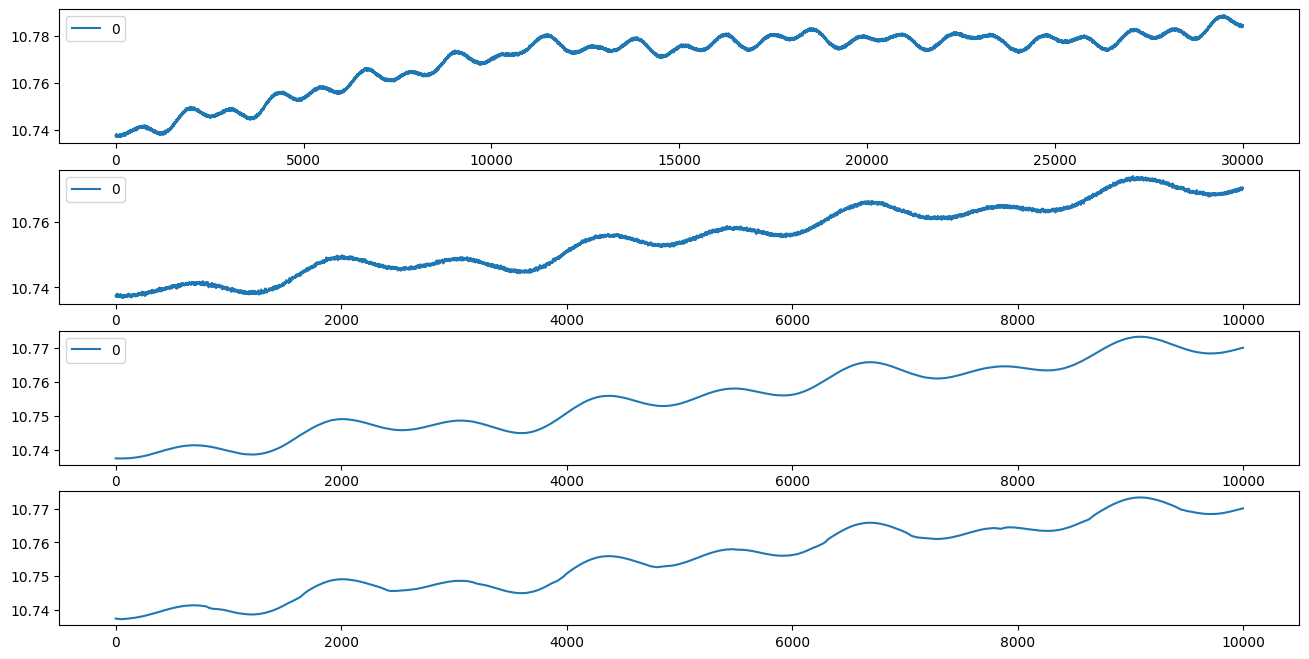

In [9]:
fig, axes = plt.subplots(4, 1, figsize=(16, 8))
for i in range(1):
    axes[0].plot(jax_tods_atmos[i] + np.float64(tod_truthmap.get_field('noise')*noiselevel)[i], label=i)
    axes[1].plot( (jax_tods_atmos[i] + np.float64(tod_truthmap.get_field('noise')*noiselevel)[i])[:10000], label=i)
    axes[2].plot( (jax_tods_atmos[i] )[:10000], label=i)
    axes[3].plot( (jax_tods_atmos[i] + jax_tods_map[i] )[:10000], label=i)
    # axes[3].plot( (jax_tods_map[i] )[:10000], label=i) 

axes[0].legend()
axes[1].legend()
axes[2].legend()

# Next, initialise nifty prior model

Start with the atmosphere TOD model. For this, we need to re-write the CorrelatedFieldMaker:

In [10]:
import jax

import jax.numpy as jnp
import numpy as np
import nifty8.re as jft
import matplotlib.pyplot as plt

from functools import partial
from nifty8.re.correlated_field import Model, RegularCartesianGrid, hartley, HEALPixGrid, get_sht, ShapeWithDtype, random_like

key = jax.random.PRNGKey(42)

In [11]:
class CFM(jft.CorrelatedFieldMaker):
    def __init__(self, prefix):
        super().__init__(prefix)

    def finalize(self, n_fields: int = 0) -> Model:
        """Finishes off the model construction process and returns the
        constructed operator.
        """
        harmonic_transforms = []
        excitation_shape = ()
        for sgrid in self._target_grids:
            sub_shp = None
            sub_shp = sgrid.harmonic_grid.shape
            excitation_shape += sub_shp
            n = len(excitation_shape)
            harmonic_dvol = 1.0 / sgrid.total_volume
            if isinstance(sgrid, RegularCartesianGrid):
                axes = tuple(range(n - len(sub_shp), n))
                # TODO: Generalize to complex
                trafo = partial(hartley, axes=axes)
            elif isinstance(sgrid, HEALPixGrid):
                axis = len(excitation_shape) - 1
                trafo = get_sht(
                    nside=sgrid.nside,
                    axis=axis,
                    lmax=sgrid.harmonic_grid.lmax,
                    mmax=sgrid.harmonic_grid.mmax,
                    nthreads=1,
                )
            harmonic_transforms.append((harmonic_dvol, trafo))

        # Register the parameters for the excitations in harmonic space
        # TODO: actually account for the dtype here
        pfx = self._prefix + "xi"
        if n_fields > 0:
            xi_shape = (n_fields,) + excitation_shape
        else:
            xi_shape = excitation_shape
        self._parameter_tree[pfx] = ShapeWithDtype(xi_shape)

        def outer_harmonic_transform(p):
            harmonic_dvol, ht = harmonic_transforms[0]
            outer = harmonic_dvol * ht(p)
            for harmonic_dvol, ht in harmonic_transforms[1:]:
                outer = harmonic_dvol * ht(outer)
            return outer

        def _mk_expanded_amp(amp, sub_dom):  # Avoid late binding
            def expanded_amp(p):
                return amp(p)[sub_dom.harmonic_grid.power_distributor]

            return expanded_amp

        expanded_amplitudes = []
        namps = self.get_normalized_amplitudes()
        for amp, sgrid in zip(namps, self._target_grids):
            expanded_amplitudes.append(_mk_expanded_amp(amp, sgrid))

        def outer_amplitude(p):
            outer = expanded_amplitudes[0](p)
            for amp in expanded_amplitudes[1:]:
                # NOTE, the order is important here and must match with the
                # excitations
                # TODO, use functions instead and utilize numpy's casting
                outer = jnp.tensordot(outer, amp(p), axes=0)
            return outer

        def correlated_field(p):
            ea = outer_amplitude(p)
            cf_h = self.azm(p) * ea * p[self._prefix + "xi"]
            return self._offset_mean + outer_harmonic_transform(cf_h)
        
        p_dct = {k: 0 if 'xi' in k else None for k in self._parameter_tree}
        cfm_vmap = jax.vmap(correlated_field, in_axes=(p_dct,))

        init = {
            k: partial(random_like, primals=v) for k, v in self._parameter_tree.items()
        }
        cf = Model(cfm_vmap, domain=self._parameter_tree.copy(), init=init)
        cf.normalized_amplitudes = namps
        cf.target_grids = tuple(self._target_grids)
        return cf

In [12]:
# padding_atmos = 2000
# padding_atmos = 5000
padding_atmos = 10000
dims_atmos = ( (jax_tods_atmos.shape[1] + padding_atmos), )
# dims_atmos = ( (jax_tods_atmos.shape[1] - 200 + padding_atmos), )

# correlated field zero mode GP offset and stddev
# cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.002, 0.001))
cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.0002, 0.0001))

# correlated field fluctuations (mostly don't need tuning)
# fluctuations: y-offset in power spectrum in fourier space (zero mode)
# loglogavgslope: power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
# flexibility=(1.5e0, 5e-1), # deviation from simple power-law
# asperity=(5e-1, 5e-2), # small scale features in power-law
cf_fl_tod = dict(
    # fluctuations=(0.005, 0.003), 
    # fluctuations=(0.001, 0.0005),
    fluctuations=(0.002, 0.001),
    # loglogavgslope=(-3, 0.5), 
    # loglogavgslope=(-2, 0.5), 
    loglogavgslope=(-2.5, 0.5), 
    flexibility=None,
    asperity=None,
)

# put together in correlated field model
# Custom CFM:
cfm_tod = CFM("combcf ")
cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
cfm_tod.add_fluctuations(
    dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
)
gp_tod = cfm_tod.finalize(n)
gp_tod

# Old: default CFM:
# cfm_tod = jft.CorrelatedFieldMaker("")
# cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
# cfm_tod.add_fluctuations(
#     dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
# )
# # init params for each TOD:
# gps_tods = []
# for i in range(n):
#     cfmi = jft.CorrelatedFieldMaker(f'tod{i} ')
#     # cfmi.set_amplitude_total_offset(**cf_zm_tod)
#     cfmi._azm = cfm_tod._azm
#     cfmi._offset_mean = cfm_tod._offset_mean
#     cfmi._parameter_tree['zeromode'] = jft.ShapeWithDtype(())

#     cfmi._fluctuations.append(cfm_tod._fluctuations[0])
#     cfmi._target_grids.append(cfm_tod._target_grids[0])
#     cfmi._parameter_tree.update(cfm_tod._fluctuations[0].domain)
#     gps_tods.append(cfmi.finalize())
# gps_tods

Model(
	<function CFM.finalize.<locals>.correlated_field at 0x153bb1bf0040>,
	domain={'combcf tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf xi': ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>),
	 'combcf zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'combcf tod fluctuations': functools.partial(<function random_like at 0x153bf946a200>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf tod loglogavgslope': functools.partial(<function random_like at 0x153bf946a200>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf xi': functools.partial(<function random_like at 0x153bf946a200>, primals=ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>)),
		 'combcf zeromode': functools.partial(<function random_like at 0x1

## Now for the map model:

In [13]:
# padding_map = 100
# dims_map = (1000 + padding_map, 1000 + padding_map)
dims_map = (1000, 1000)

# Map model

# correlated field zero mode GP offset and stddev
# cf_zm_map = dict(offset_mean=mapdata_truth.mean(), offset_std=(1e-7, 1e-6))
cf_zm_map = dict(offset_mean=mapdata_truth.mean(), offset_std=(1e-8, 1e-7))
# correlated field fluctuations (mostly don't need tuning)
cf_fl_map = dict(
    # fluctuations=(1e-6, 1e-6), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    # fluctuations=(2e-6, 1e-6), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    fluctuations=(4.5e-5, 2e-5),
    loglogavgslope=(-2.5e0, 5e-1), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    flexibility=None,
    asperity=None,
    # flexibility=(1.5e0, 5e-1), # deviation from simple power-law
    # asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm_map = jft.CorrelatedFieldMaker("cfmap")
cfm_map.set_amplitude_total_offset(**cf_zm_map)
cfm_map.add_fluctuations(
    dims_map, distances=1.0 / dims_map[0], **cf_fl_map, prefix="ax1", non_parametric_kind="power"
)
gp_map = cfm_map.finalize()

# Define offset NormalPrior:

mean deviation: 3.096182876561914e-15
deviation std: 0.57424192447616
offset for n dets: [-0.55658969  0.70598044  0.45848624 -0.5097602  -0.23727377  0.07171732
 -1.69571101 -0.47689752  0.09323307 -0.05505829  1.02706448 -0.0304073
 -1.06656175  0.59146975 -0.30434225  0.3919226  -0.38781481  0.10400879
 -0.0996848  -0.5910109   0.61976674  0.75905213  0.36381721 -0.9212461
  1.00644164  0.89144768 -0.86327198 -1.61355723 -0.49998147 -0.91128731
 -0.22462431 -0.17854716 -0.81210023 -0.33571686 -0.16880674 -0.01364307
 -0.14908651 -0.59906994  0.19962824  0.39380501 -0.63937048  0.74979831
 -1.2341984  -0.12748694  0.0995497  -1.42178941  0.90958114 -0.07488798
  0.16155921  0.79075766 -0.30061962  0.68646881 -0.13132886  0.12073598
  0.03861593 -0.32911474  0.67303244 -0.52667606  1.1679566  -0.2312586
  0.50741469 -0.72636437 -0.47444869 -0.60691119 -0.6451688  -0.70305466
  0.52157375  0.24956016 -0.28464324 -0.61209363 -0.63847182  0.18321905
 -0.1693497  -0.08185761 -0.17380788  

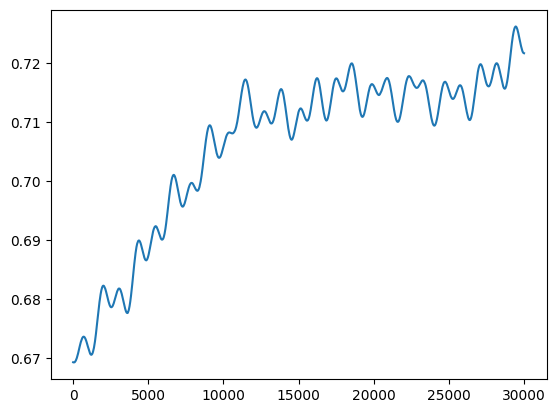

In [14]:
deviation = jax_tods_atmos - jax_tods_atmos.mean()

print("mean deviation:", deviation.mean().compute())
print("deviation std:", deviation.std().compute())

offset_tod = jnp.float64(deviation.mean(axis=1)[:n].compute())
print("offset for n dets:", offset_tod)

plt.plot(deviation[1])

In [15]:
offset_dict = dict(mean = 0.0, std = 0.6, shape=(n,))
offset_tod = jft.NormalPrior(**offset_dict, name='offset')

offset_tod

NormalPrior(
	<function wrap.<locals>.named_call at 0x153b801a4d60>,
	domain={'offset': ShapeWithDtype(shape=(217,), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer({'offset': functools.partial(<function random_like at 0x153bf946a200>, primals=ShapeWithDtype(shape=(217,), dtype=<class 'jax.numpy.float64'>))})
)

# OLD Signal model:

In [16]:
# class Signal_TOD(jft.Model):
#     def __init__(self, gps_tods, gp_map):
#         self.gps_tods = gps_tods
#         self.tgt = (len(gps_tods), gps_tods[0].target.size)
#         self.gp_map = gp_map
#         super().__init__(init=reduce(or_, [gp.init for gp in gps_tods] + [gp_map.init]), domain=reduce(or_, [gp.domain for gp in gps_tods] + [gp_map.domain]))
    
#     def __call__(self, x):
#         res_tods = jnp.zeros(self.tgt)
#         for i, gp in enumerate(self.gps_tods):
#             res_tods = res_tods.at[i].set(gp(x))
        
#         res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

#         # Only add first n atmosphere tods, otherwise use map
#         modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])

#         return modified_res_map

# signal_response_tod = Signal_TOD(gps_tods, gp_map)

# Using CFM - combined

In [16]:
class Signal_TOD(jft.Model):
    def __init__(self, gp_tod, offset_tod, gp_map):
        self.gp_tod = gp_tod
        self.gp_map = gp_map
        self.offset_tod = offset_tod

        super().__init__(init = self.gp_tod.init | self.gp_map.init | self.offset_tod.init,
                         domain = self.gp_tod.domain | self.gp_map.domain | self.offset_tod.domain)
        # super().__init__(init = self.gp_tod.init | self.gp_map.init,
        #                 domain = self.gp_tod.domain | self.gp_map.domain )


    def __call__(self, x):
        x_tod = {k: x[k] for k in x if 'comb' in k}
        res_tods = self.gp_tod(x_tod)
        # res_tods = self.gp_tod(x['tod'])

        res_tods_offset = res_tods[:, padding_atmos//2:-padding_atmos//2] + self.offset_tod(x)[:, jax.numpy.newaxis]
        # res_tods_offset = res_tods[:, padding_atmos//2:-padding_atmos//2] + self.offset_tod[:, jax.numpy.newaxis]

        # res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1]))[:, padding_map//2:-padding_map//2, padding_map//2:-padding_map//2], dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
        res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
        # Only add first n atmosphere tods, otherwise use map
        # modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])
        modified_res_map = res_map.at[:n, :].add(res_tods_offset)

        return modified_res_map
    
signal_response_tod = Signal_TOD(gp_tod, offset_tod, gp_map)

# map-only:

In [17]:
# class Signal_TOD(jft.Model):
#     def __init__(self, gp_map):
#         self.gp_map = gp_map

#         # super().__init__(init = self.gp_tod.init | self.gp_map.init | self.offset_tod.init,
#         #                  domain = self.gp_tod.domain | self.gp_map.domain | self.offset_tod.domain)
#         super().__init__(init = self.gp_map.init,
#                         domain = self.gp_map.domain )


#     def __call__(self, x):
#         res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

#         return res_map
    
# signal_response_tod = Signal_TOD(gp_map)

# CFM - TOD

In [18]:
# class Signal_TOD(jft.Model):
#     def __init__(self, gp_tod):
#         self.gp_tod = gp_tod
#         super().__init__(init = self.gp_tod.init, domain = self.gp_tod.domain )
    
#     def __call__(self, x):
#         x_tod = {k: x[k] for k in x if 'map' not in k}
#         res_tods = self.gp_tod(x_tod)
#         # res_tods = self.gp_tod(x)

#         return res_tods[:, padding_atmos//2:-padding_atmos//2]

# signal_response_tod = Signal_TOD(gp_tod)

In [19]:
# Define noise covariance
# if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x

# Combine in likelihood - only fit 0th TOD for now!
# truth = noised_jax_tod[:n]
truth = noised_jax_tod
print(noised_jax_tod.shape)
# truth = noised_jax_tod[:, 100:-100]
lh_tod = jft.Gaussian( truth, noise_cov_inv_tod).amend(signal_response_tod)

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

# lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


(217, 30000)


In [20]:
signal_response_tod

Signal_TOD(
	<bound method Signal_TOD.__call__>,
	domain={'cfmapax1fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfmapax1loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfmapxi': ShapeWithDtype(shape=(1000, 1000), dtype=<class 'jax.numpy.float64'>),
	 'cfmapzeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf xi': ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>),
	 'combcf zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'offset': ShapeWithDtype(shape=(217,), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'cfmapax1fluctuations': functools.partial(<function random_like at 0x153bf946a200>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),


# Draw Prior sample

(217, 30000)


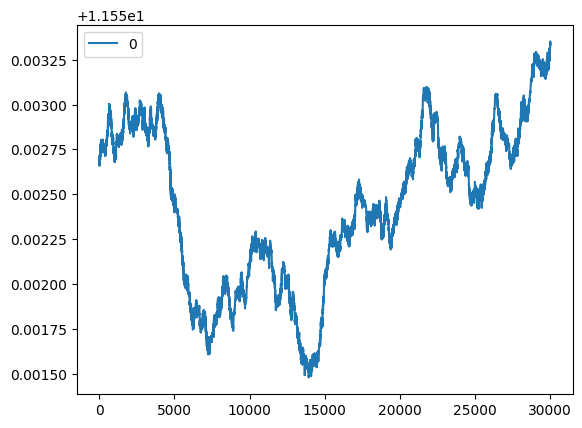

In [21]:
key, sub = jax.random.split(key)
xi = jft.random_like(sub, signal_response_tod.domain)
res = signal_response_tod(xi)
print(res.shape)

# for i in range(res.shape[0]):
# for i in range(0, n, n//10):
for i in [0]:
    plt.plot(np.arange(0, res.shape[1]), res[i], label=i)
plt.legend()
plt.show()

# MAP fit

In [22]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:1.0 ↺:False #∇²:06 |↘|:1.047381e+04 ➽:9.680223e+02
M: Iteration 1 ⛰:+7.319728e+09 Δ⛰:3.543728e+13
M: →:1.0 ↺:True #∇²:13 |↘|:4.987442e-01 ➽:9.680223e+02
M: Iteration 2 ⛰:+7.210311e+09 Δ⛰:1.094168e+08
OPTIMIZE_KL: Iteration 0001 ⛰:+7.2103e+09
OPTIMIZE_KL: #(KL minimization steps) 2
OPTIMIZE_KL: Likelihood residual(s):
'reduced χ²: 2.2e+03±     0.0, avg:    -0.12±     0.0, #dof:6510000'

OPTIMIZE_KL: Prior residual(s):
cfmapax1fluctuations    :: 'reduced χ²: 2.1e+01±     0.0, avg:     -4.6±     0.0, #dof:      1'
cfmapax1loglogavgslope  :: 'reduced χ²:    0.36±     0.0, avg:     +0.6±     0.0, #dof:      1'
cfmapxi                 :: 'reduced χ²:     1.0±     0.0, avg: -0.00055±     0.0, #dof:1000000'
cfmapzeromode           :: 'reduced χ²:    0.82±     0.0, avg:    +0.91±     0.0, #dof:      1'
combcf tod fluctuations :: 'reduced χ²: 3.5e+01±     0.0, avg:     -5.9±     0.0, #dof:      1'
combcf tod loglogavgslope:: 'reduced χ²:   0.039±     0.0, avg:    

In [23]:
samples.pos

Vector(
	{'cfmapax1fluctuations': Array(-4.5668065, dtype=float64),
	 'cfmapax1loglogavgslope': Array(0.59587998, dtype=float64),
	 'cfmapxi': Array([[ 0.78132751,  5.29009868,  0.6167422 , ..., -0.2293983 ,
	        -0.19628809, -2.72907644],
	       [-3.59069456,  1.68068919,  0.57733561, ...,  1.07974834,
	         0.18840801,  0.41792197],
	       [ 1.94440911,  1.49751842, -1.71607514, ..., -0.67284518,
	         0.64061849,  0.13922107],
	       ...,
	       [ 0.83800107,  0.38301881,  0.72474659, ...,  0.25898775,
	        -0.6314559 , -0.70778548],
	       [-0.18606337,  0.06292034, -0.82915428, ..., -0.46233423,
	         0.2006597 ,  0.59753031],
	       [ 3.26734373, -1.94612163, -0.89675952, ...,  0.60333093,
	         1.02538553, -1.26879584]], dtype=float64),
	 'cfmapzeromode': Array(0.90780101, dtype=float64),
	 'combcf tod fluctuations': Array(-5.91141098, dtype=float64),
	 'combcf tod loglogavgslope': Array(0.19668758, dtype=float64),
	 'combcf xi': Array([[-4.80140267

In [24]:
def printfitresults():
    print("Fit Results (res, init, std)")

    print("\nTODs:")
    # # NEW model:
    print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['combcf tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['combcf tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['combcf zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")
    # OLD model:
    # print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    # print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    # print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")

    # offset per detector:
    offset_results = jft.NormalPrior(**offset_dict)(samples.pos['offset'])
    print(f"\toffset: ({offset_results.mean()}, {offset_results.std()}), {offset_dict['mean']}, {offset_dict['std']}")
    # residual offset:
    offset_residuals = offset_results - jnp.float64(deviation.mean(axis=1)[:n].compute())
    print(f"\toffset residuals: ({offset_residuals.mean()}, {offset_residuals.std()})")

    # If custom zeromode per TOD:
    # for i in range(n):
    #     test = samples.pos[f"tod{i} zeromode"]
    #     print(f"tod{i} zeromode: {jft.LogNormalPrior(cf_zm_tod['offset_mean'], cf_zm_tod['offset_std'][0])(test)}, {cf_zm_tod['offset_mean']}, {cf_zm_tod['offset_std'][0]}")
    
    print("map:")
    print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_map['fluctuations'])(samples.pos['cfmapax1fluctuations'])}, {cf_fl_map['fluctuations'][0]}, {cf_fl_map['fluctuations'][1]}")
    print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_map['loglogavgslope'])(samples.pos['cfmapax1loglogavgslope'])}, {cf_fl_map['loglogavgslope'][0]}, {cf_fl_map['loglogavgslope'][1]}")
    print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_map['offset_std'])(samples.pos['cfmapzeromode'])}, {cf_zm_map['offset_std'][0]}, {cf_zm_map['offset_std'][1]}")
    
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.00010960621355820517, 0.002, 0.001
	loglogvarslope: -2.4016562075133665, -2.5, 0.5
	zeromode std (LogNormal): 0.00015158911367272638, 0.0002, 0.0001
	offset: (-0.0002414091389565914, 0.5740880252056395), 0.0, 0.6
	offset residuals: (-0.000241409138974295, 0.0001525451903303814)
map:
	fluctuations: 5.915588817911484e-06, 4.5e-05, 2e-05
	loglogvarslope: -2.2020600097259684, -2.5, 0.5
	zeromode std (LogNormal): 6.9952997317069044e-09, 1e-08, 1e-07


(217, 30000)


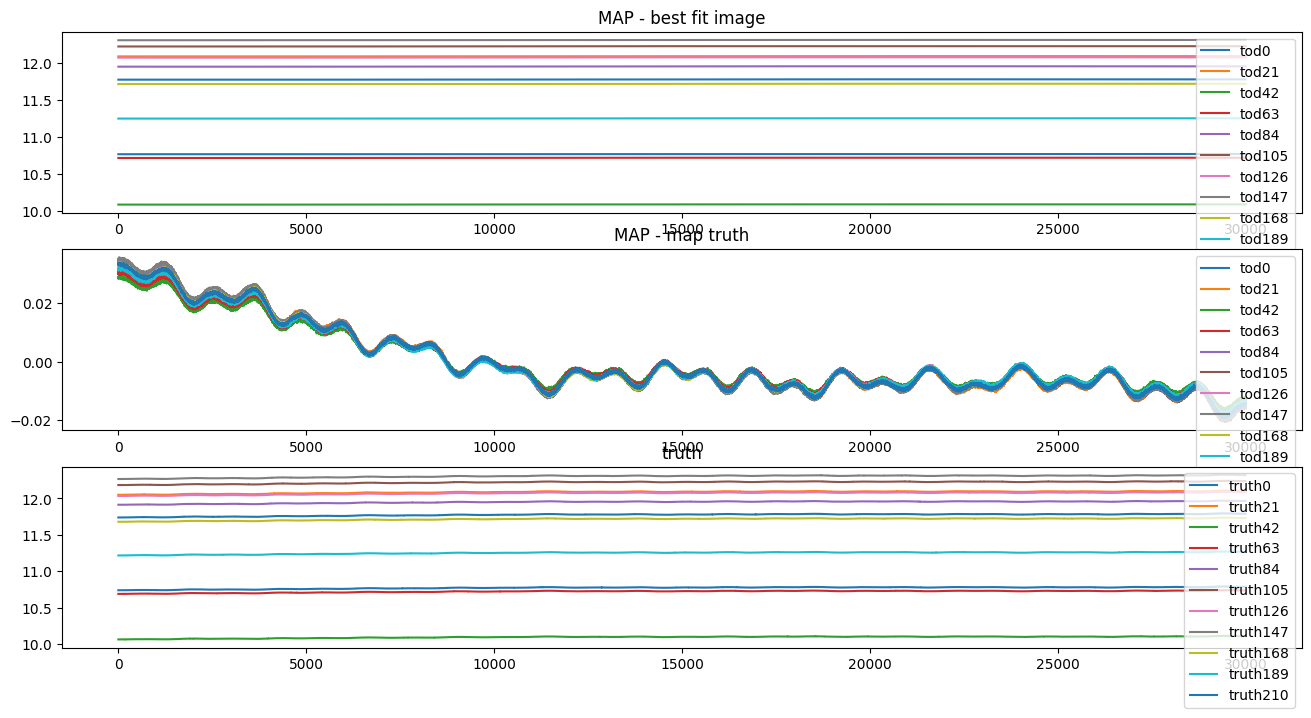

In [25]:
res = signal_response_tod(samples.pos)
print(res.shape)

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

# for i in range(0, res.shape[0], res.shape[0]//10):
for i in range(0, n, n//10):
    im0 = axes[0].plot(np.arange(0, res.shape[1]), res[i], label=f"tod{i}")
    im1 = axes[1].plot(np.arange(0, res.shape[1]), res[i] - truth[i], label=f"tod{i}")
    im2 = axes[2].plot(truth[i], label=f"truth{i}")

axes[0].title.set_text('MAP - best fit image')
axes[0].legend()
axes[1].title.set_text('MAP - map truth')
axes[1].legend()
axes[2].title.set_text('truth')
axes[2].legend()

plt.show()

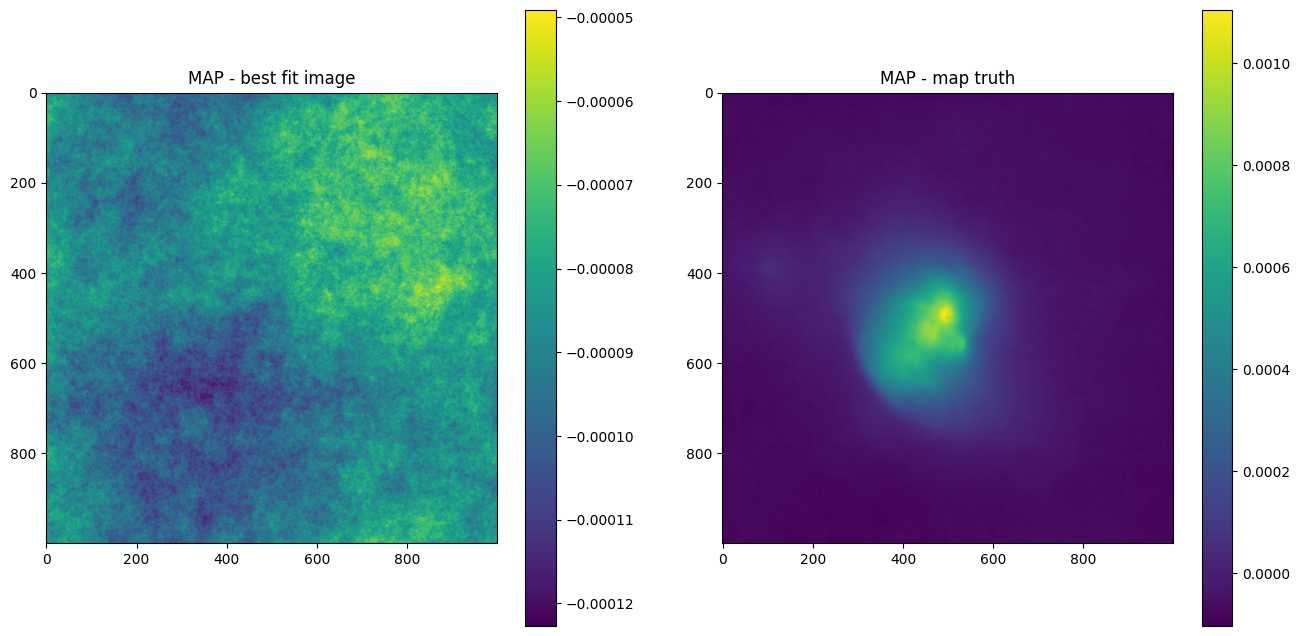

In [26]:
# plot maximum of posterior (mode)
# sig_map = gp_map(samples.pos)[padding_map//2:-padding_map//2, padding_map//2:-padding_map//2] # when splitting up in different field models
sig_map = gp_map(samples.pos)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('MAP - best fit image')
fig.colorbar(im0)

im1 = axes[1].imshow( sig_map - mapdata_truth[0] )
axes[1].title.set_text('MAP - map truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()

In [28]:
# assert False

## Full nifty fit:

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+1.8046e+13 Δ⛰:inf ➽:9.6802e+01
SL: Iteration 1 ⛰:+1.8763e+08 Δ⛰:1.8046e+13 ➽:9.6802e+01
SL: Iteration 2 ⛰:+1.8662e+08 Δ⛰:1.0095e+06 ➽:9.6802e+01
SL: Iteration 3 ⛰:+1.5810e+08 Δ⛰:2.8519e+07 ➽:9.6802e+01
SL: Iteration 4 ⛰:+1.4910e+08 Δ⛰:9.0031e+06 ➽:9.6802e+01
SL: Iteration 5 ⛰:+1.4898e+08 Δ⛰:1.2002e+05 ➽:9.6802e+01
SL: Iteration 6 ⛰:+4.8765e+07 Δ⛰:1.0022e+08 ➽:9.6802e+01
SL: Iteration 7 ⛰:+4.8765e+07 Δ⛰:1.2775e+02 ➽:9.6802e+01
SL: Iteration 8 ⛰:+2.9433e+07 Δ⛰:1.9332e+07 ➽:9.6802e+01
SL: Iteration 9 ⛰:+2.7377e+07 Δ⛰:2.0565e+06 ➽:9.6802e+01
SL: Iteration 10 ⛰:+1.5973e+07 Δ⛰:1.1404e+07 ➽:9.6802e+01
SL: Iteration 11 ⛰:+1.1128e+07 Δ⛰:4.8453e+06 ➽:9.6802e+01
SL: Iteration 12 ⛰:+1.1125e+07 Δ⛰:2.8231e+03 ➽:9.6802e+01
SL: Iteration 13 ⛰:+7.9809e+06 Δ⛰:3.1440e+06 ➽:9.6802e+01
SL: Iteration 14 ⛰:+7.9781e+06 Δ⛰:2.8076e+03 ➽:9.6802e+01
SL: Iteration 15 ⛰:+7.7152e+06 Δ⛰:2.6290e+05 ➽:9.6802e+01
SL: Iteration 16 ⛰:+7.7141e+06 Δ⛰:1.1792e+03 ➽:9.6802e+01
SL: 

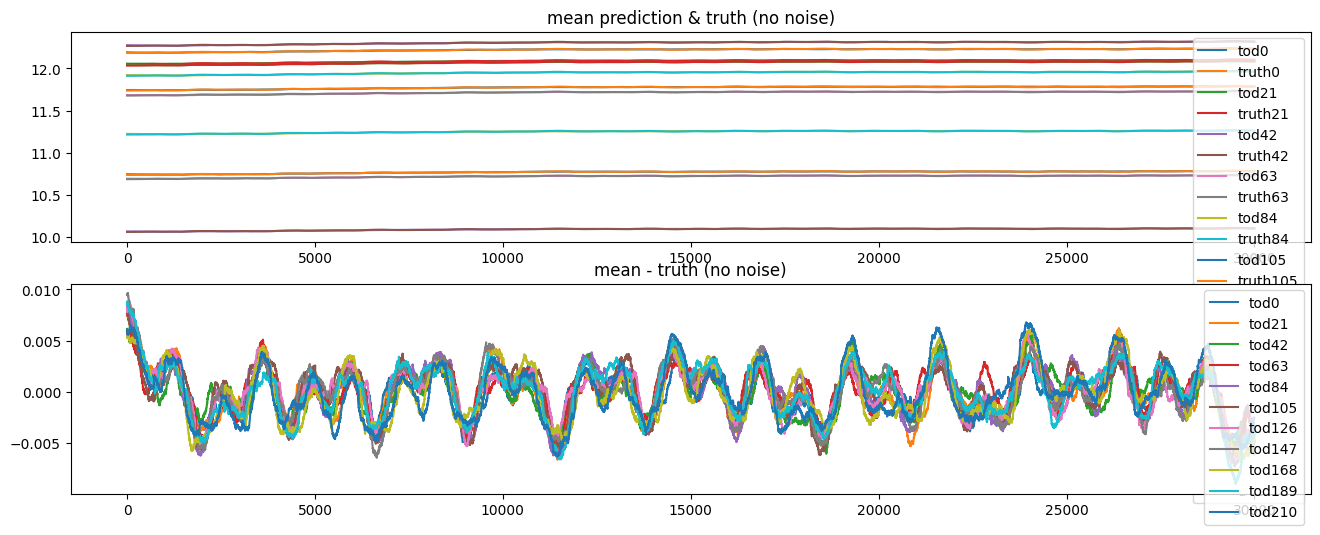

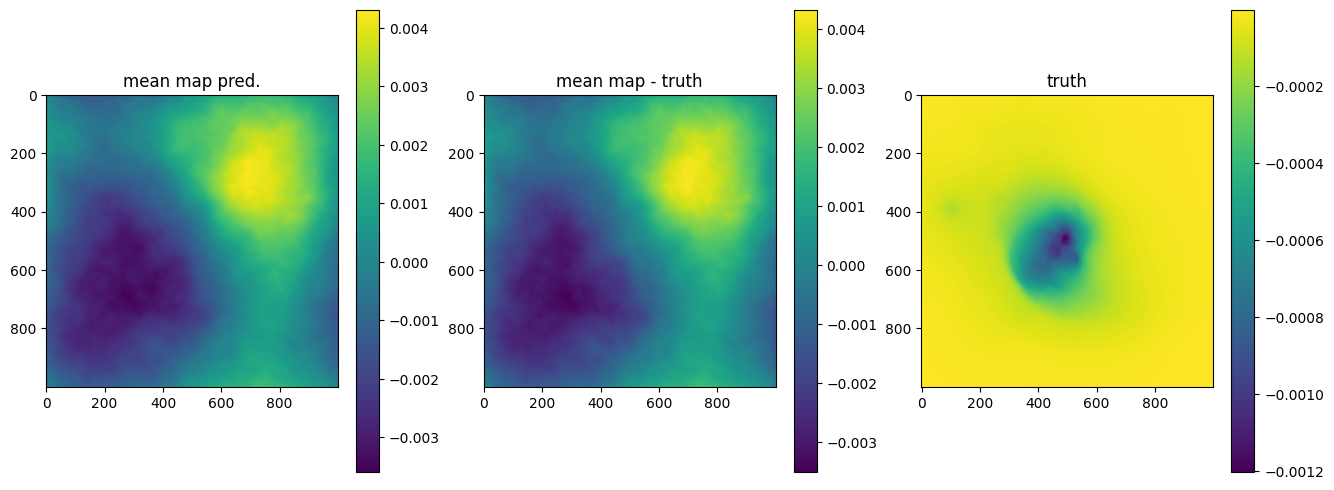

OPTIMIZE_KL: Starting 0006
SL: Iteration 0 ⛰:+1.8953e+13 Δ⛰:inf ➽:9.6802e+01
SL: Iteration 1 ⛰:+3.2733e+08 Δ⛰:1.8953e+13 ➽:9.6802e+01
SL: Iteration 2 ⛰:+2.3898e+08 Δ⛰:8.8346e+07 ➽:9.6802e+01
SL: Iteration 3 ⛰:+2.2787e+08 Δ⛰:1.1118e+07 ➽:9.6802e+01
SL: Iteration 4 ⛰:+2.2142e+08 Δ⛰:6.4437e+06 ➽:9.6802e+01
SL: Iteration 5 ⛰:+2.2024e+08 Δ⛰:1.1816e+06 ➽:9.6802e+01
SL: Iteration 6 ⛰:+1.8939e+08 Δ⛰:3.0850e+07 ➽:9.6802e+01
SL: Iteration 7 ⛰:+1.8930e+08 Δ⛰:9.0272e+04 ➽:9.6802e+01
SL: Iteration 8 ⛰:+6.6710e+07 Δ⛰:1.2259e+08 ➽:9.6802e+01
SL: Iteration 9 ⛰:+6.6671e+07 Δ⛰:3.9253e+04 ➽:9.6802e+01
SL: Iteration 10 ⛰:+4.2916e+07 Δ⛰:2.3755e+07 ➽:9.6802e+01
SL: Iteration 11 ⛰:+4.2897e+07 Δ⛰:1.8484e+04 ➽:9.6802e+01
SL: Iteration 12 ⛰:+4.1368e+07 Δ⛰:1.5290e+06 ➽:9.6802e+01
SL: Iteration 13 ⛰:+3.1269e+07 Δ⛰:1.0099e+07 ➽:9.6802e+01
SL: Iteration 14 ⛰:+3.1269e+07 Δ⛰:1.1314e+02 ➽:9.6802e+01
SL: Iteration 15 ⛰:+2.2278e+07 Δ⛰:8.9911e+06 ➽:9.6802e+01
SL: Iteration 16 ⛰:+2.2214e+07 Δ⛰:6.3560e+04 ➽:9.6802e+01
SL: 

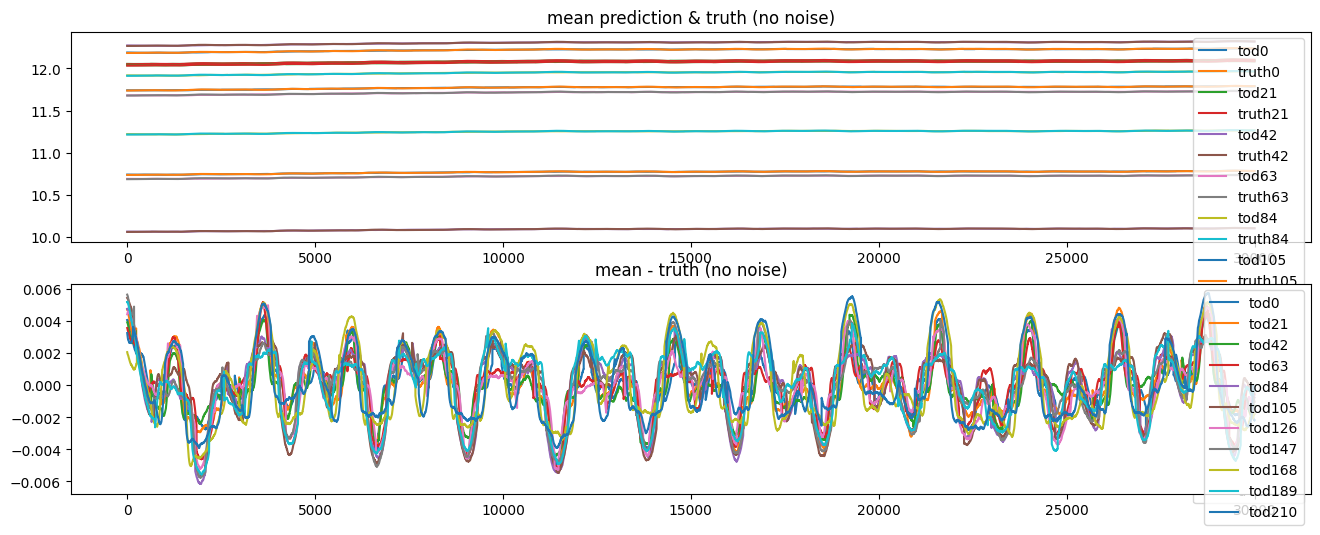

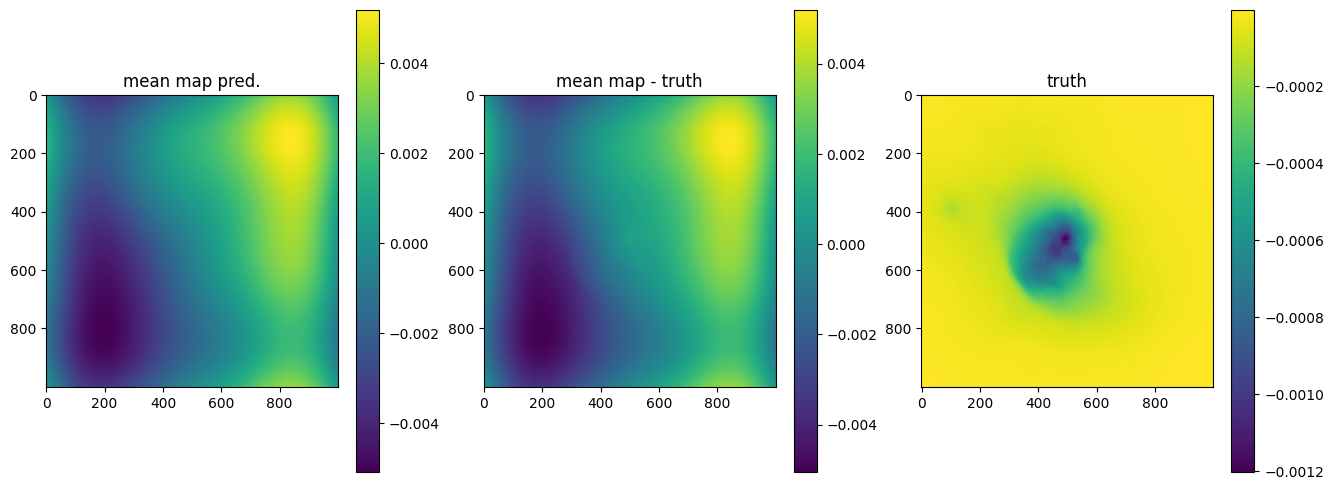

OPTIMIZE_KL: Starting 0011
SL: Iteration 0 ⛰:+1.8469e+13 Δ⛰:inf ➽:9.6802e+01
SL: Iteration 1 ⛰:+4.4654e+08 Δ⛰:1.8469e+13 ➽:9.6802e+01
SL: Iteration 2 ⛰:+2.7040e+08 Δ⛰:1.7614e+08 ➽:9.6802e+01
SL: Iteration 3 ⛰:+2.6423e+08 Δ⛰:6.1669e+06 ➽:9.6802e+01
SL: Iteration 4 ⛰:+2.2346e+08 Δ⛰:4.0774e+07 ➽:9.6802e+01
SL: Iteration 5 ⛰:+2.2298e+08 Δ⛰:4.8512e+05 ➽:9.6802e+01
SL: Iteration 6 ⛰:+1.6472e+08 Δ⛰:5.8257e+07 ➽:9.6802e+01
SL: Iteration 7 ⛰:+1.6465e+08 Δ⛰:6.7377e+04 ➽:9.6802e+01
SL: Iteration 8 ⛰:+4.6274e+07 Δ⛰:1.1838e+08 ➽:9.6802e+01
SL: Iteration 9 ⛰:+4.6274e+07 Δ⛰:2.5536e+02 ➽:9.6802e+01
SL: Iteration 10 ⛰:+2.8896e+07 Δ⛰:1.7378e+07 ➽:9.6802e+01
SL: Iteration 11 ⛰:+2.8787e+07 Δ⛰:1.0885e+05 ➽:9.6802e+01
SL: Iteration 12 ⛰:+2.3033e+07 Δ⛰:5.7537e+06 ➽:9.6802e+01
SL: Iteration 13 ⛰:+2.1880e+07 Δ⛰:1.1536e+06 ➽:9.6802e+01
SL: Iteration 14 ⛰:+2.1830e+07 Δ⛰:4.9074e+04 ➽:9.6802e+01
SL: Iteration 15 ⛰:+9.6022e+06 Δ⛰:1.2228e+07 ➽:9.6802e+01
SL: Iteration 16 ⛰:+9.6018e+06 Δ⛰:3.2383e+02 ➽:9.6802e+01
SL: 

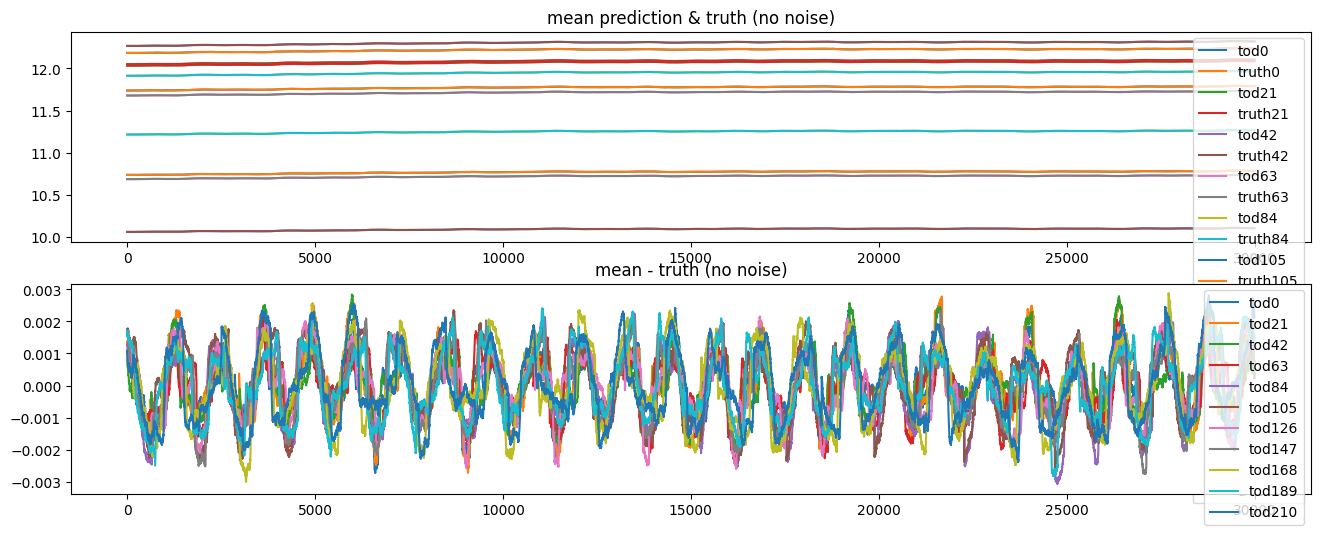

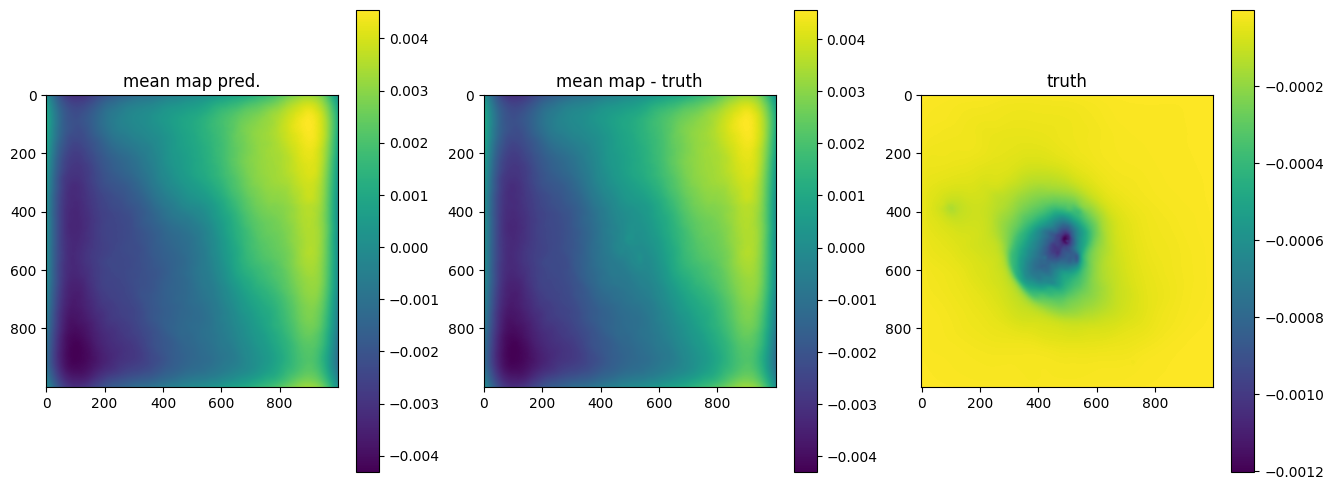

OPTIMIZE_KL: Starting 0016
SL: Iteration 0 ⛰:+2.0127e+13 Δ⛰:inf ➽:9.6802e+01
SL: Iteration 1 ⛰:+2.7561e+08 Δ⛰:2.0127e+13 ➽:9.6802e+01
SL: Iteration 2 ⛰:+2.2988e+08 Δ⛰:4.5738e+07 ➽:9.6802e+01
SL: Iteration 3 ⛰:+2.0707e+08 Δ⛰:2.2806e+07 ➽:9.6802e+01
SL: Iteration 4 ⛰:+1.7876e+08 Δ⛰:2.8305e+07 ➽:9.6802e+01
SL: Iteration 5 ⛰:+1.7868e+08 Δ⛰:8.8663e+04 ➽:9.6802e+01
SL: Iteration 6 ⛰:+1.5738e+08 Δ⛰:2.1296e+07 ➽:9.6802e+01
SL: Iteration 7 ⛰:+1.5736e+08 Δ⛰:2.3689e+04 ➽:9.6802e+01
SL: Iteration 8 ⛰:+4.5714e+07 Δ⛰:1.1164e+08 ➽:9.6802e+01
SL: Iteration 9 ⛰:+4.5713e+07 Δ⛰:1.1935e+02 ➽:9.6802e+01
SL: Iteration 10 ⛰:+2.7171e+07 Δ⛰:1.8543e+07 ➽:9.6802e+01
SL: Iteration 11 ⛰:+2.7151e+07 Δ⛰:1.9586e+04 ➽:9.6802e+01
SL: Iteration 12 ⛰:+2.5774e+07 Δ⛰:1.3768e+06 ➽:9.6802e+01
SL: Iteration 13 ⛰:+1.3493e+07 Δ⛰:1.2281e+07 ➽:9.6802e+01
SL: Iteration 14 ⛰:+1.3493e+07 Δ⛰:7.9185e+02 ➽:9.6802e+01
SL: Iteration 15 ⛰:+1.0265e+07 Δ⛰:3.2274e+06 ➽:9.6802e+01
SL: Iteration 16 ⛰:+1.0204e+07 Δ⛰:6.1613e+04 ➽:9.6802e+01
SL: 

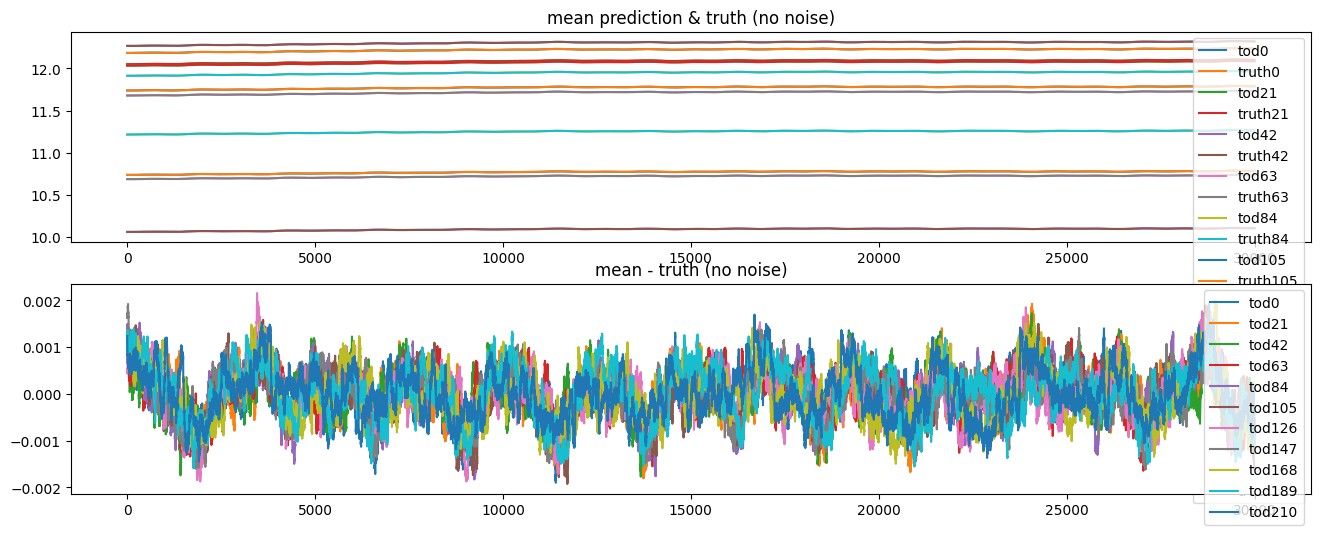

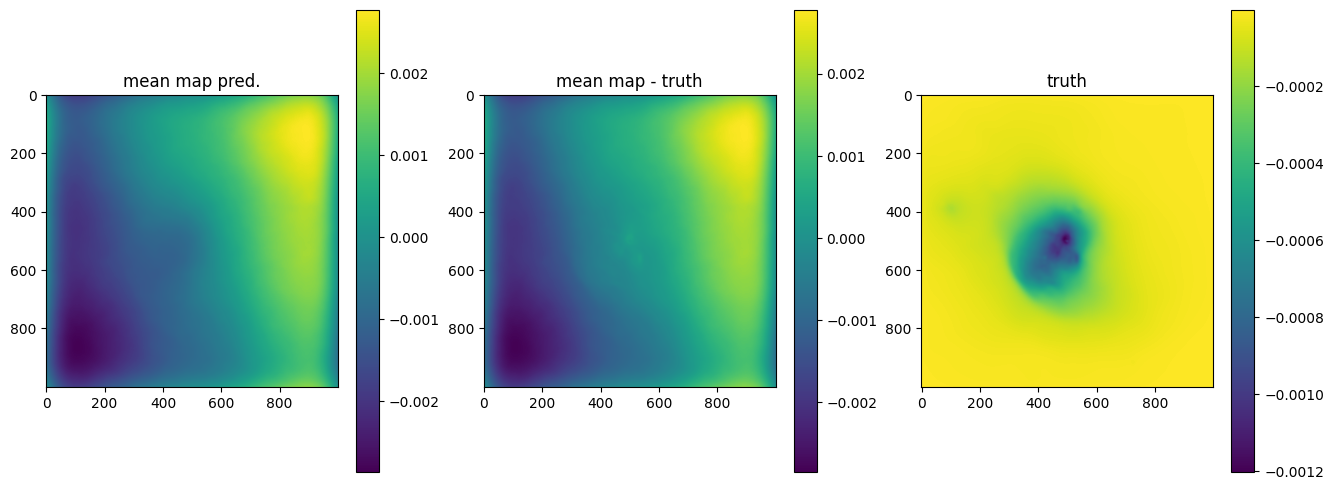

In [30]:
n_it = 20
# n_it = 50
# n_it = 250

if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    iter = opt_state[0]
    printevery = 5
    if iter % printevery != 0: return

    mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

    fig_tods, axes_tods = plt.subplots(2, 1, figsize=(16, 6))

    # for i in range(0, mean.shape[0], mean.shape[0]//10):
    # for i in range(n):
    for i in range(0, n, n//10):
        axes_tods[0].plot(np.arange(0, mean.shape[1]), mean[i], label=f"tod{i}")
        axes_tods[0].plot(denoised_jax_tod[i], label=f"truth{i}")
        axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - denoised_jax_tod[i], label=f"tod{i}")
        # axes_tods[0].plot(denoised_jax_tod[i, 100:-100], label=f"truth{i}")
        # axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - denoised_jax_tod[i, 100:-100], label=f"tod{i}")

    axes_tods[0].title.set_text('mean prediction & truth (no noise)')
    axes_tods[0].legend()
    axes_tods[1].title.set_text('mean - truth (no noise)')
    axes_tods[1].legend()

    fig_map, axes_map = plt.subplots(1, 3, figsize=(16, 6))

    # mean_map, _ = jft.mean_and_std(tuple(gp_map(s)[padding_map//2:-padding_map//2, padding_map//2:-padding_map//2] for s in samples))
    mean_map, _ = jft.mean_and_std(tuple(gp_map(s) for s in samples))

    im0 = axes_map[0].imshow(mean_map)
    axes_map[0].title.set_text('mean map pred.')
    fig_map.colorbar(im0)

    im1 = axes_map[1].imshow(mean_map - mapdata_truth[0])
    axes_map[1].title.set_text('mean map - truth')
    fig_map.colorbar(im1)

    im2 = axes_map[2].imshow(mapdata_truth[0])
    axes_map[2].title.set_text('truth')
    fig_map.colorbar(im2)

    plt.show()
    

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=10),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=10
        )
    ),
    # sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    sample_mode = lambda x: "nonlinear_resample" if x >= 1 else "linear_resample",
    callback=callback,
)

In [31]:
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.0015987859076238618, 0.002, 0.001
	loglogvarslope: -1.8161292188756406, -2.5, 0.5
	zeromode std (LogNormal): 0.000758251856209471, 0.0002, 0.0001
	offset: (-0.0024087566371823717, 0.5739152715079312), 0.0, 0.6
	offset residuals: (-0.0024087566372000715, 0.0007988566403507051)
map:
	fluctuations: 0.000156995851842472, 4.5e-05, 2e-05
	loglogvarslope: -4.055930217304024, -2.5, 0.5
	zeromode std (LogNormal): 1.375733450742527e-10, 1e-08, 1e-07


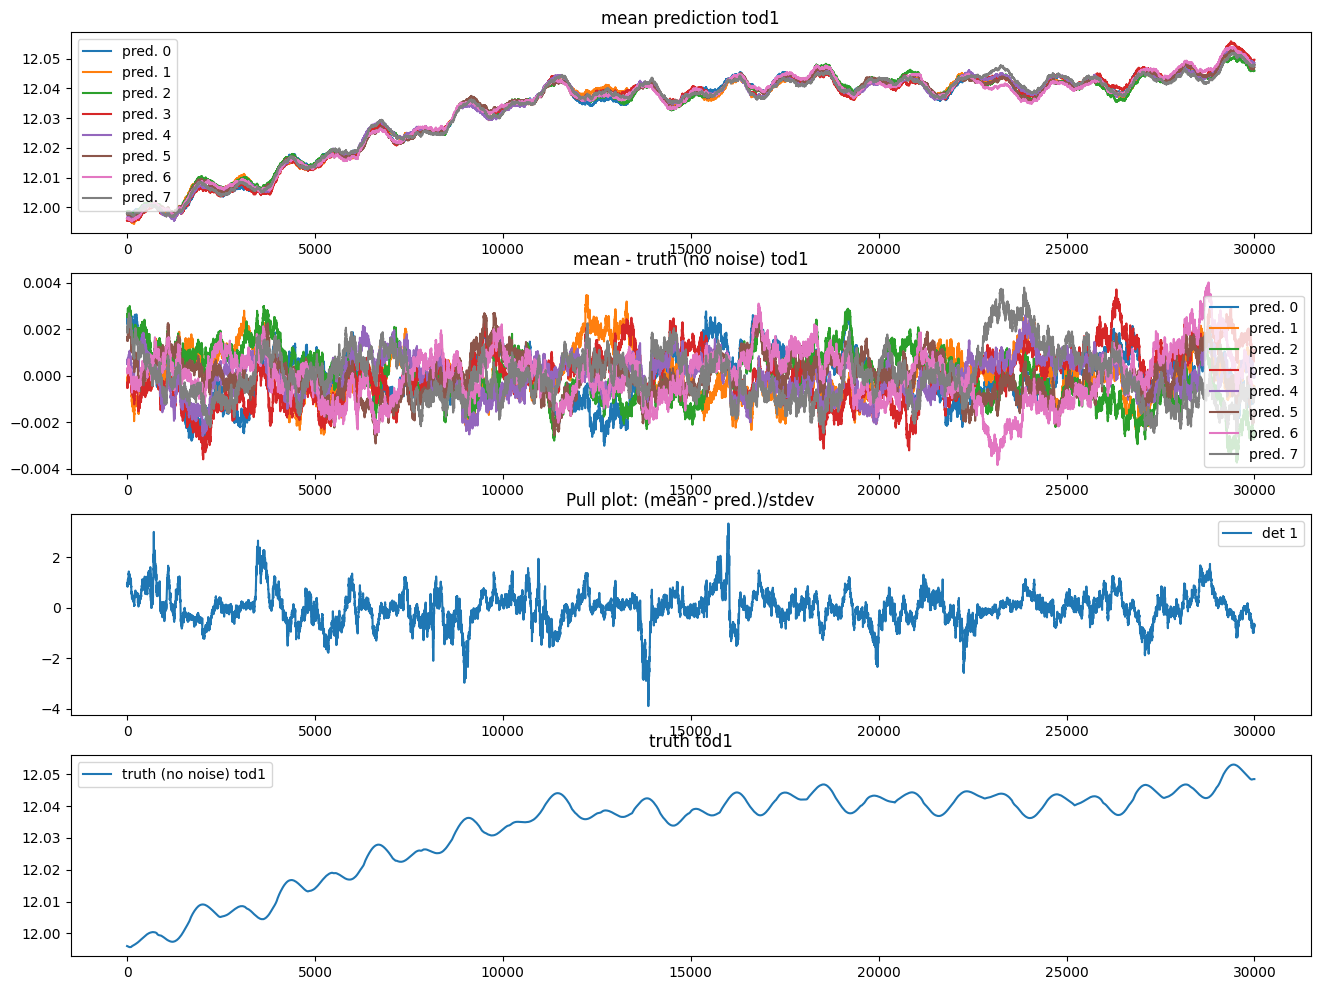

In [32]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 1 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    # im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i, 100:-100], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
# im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i, 100:-100])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()

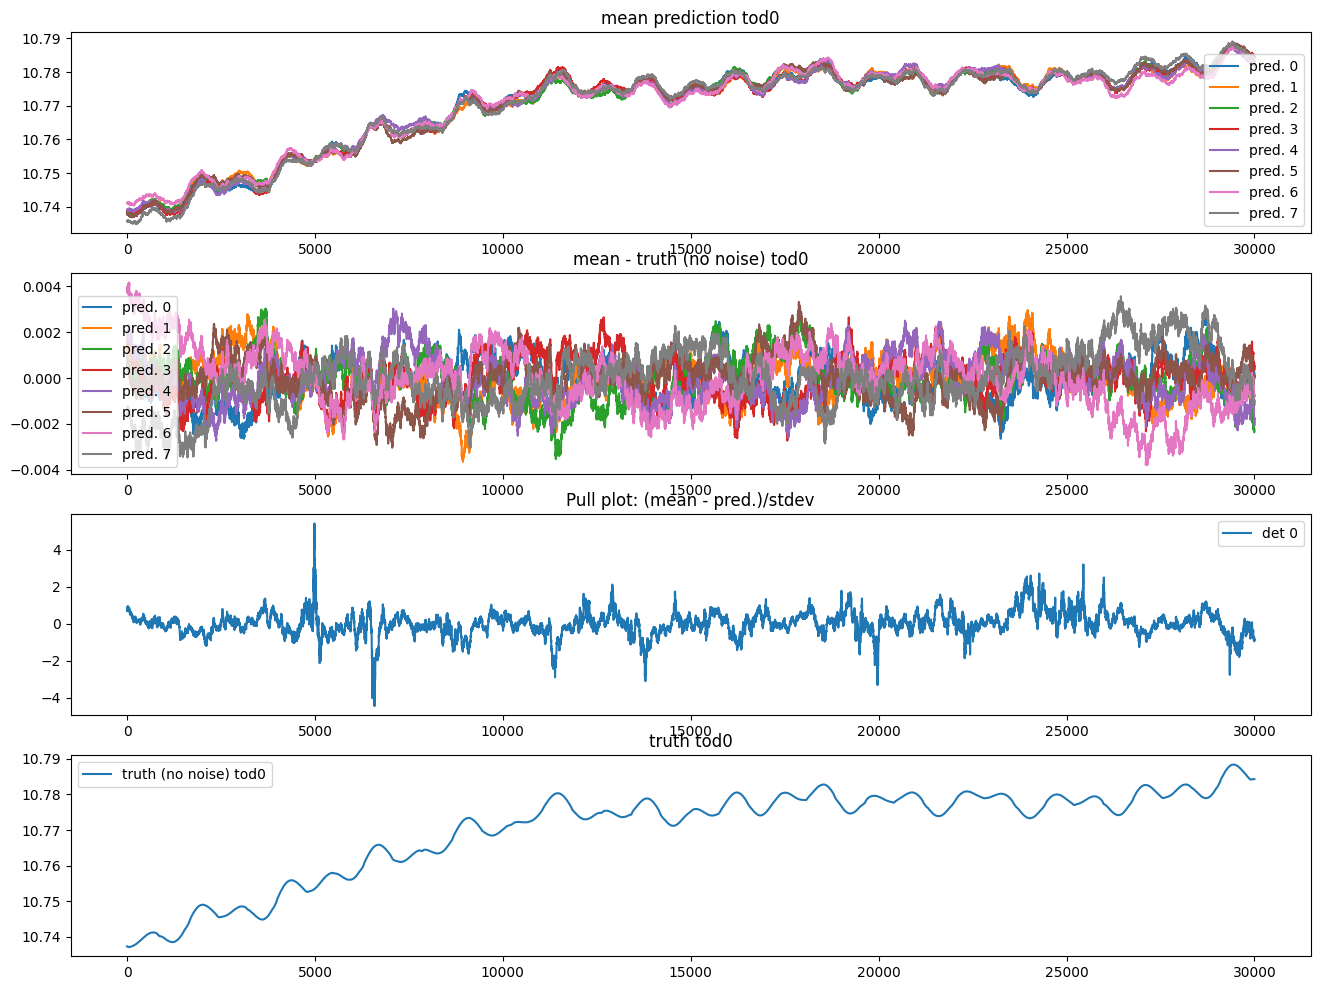

In [33]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 0 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    # im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i, 100:-100], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
# im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i, 100:-100])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()

## Compare with maria mapper:

In [34]:
from maria.map.mappers import BinMapper

mapper = BinMapper(center=(150, 10),
                   frame="ra_dec",
                   width=0.1,
                   height=0.1,
                   resolution=2e-4,
                   tod_preprocessing={
                        "window": {"tukey": {"alpha": 0.1}},
                        "remove_modes": {"n": 1},
                        "filter": {"f_lower": 0.01},
                        "despline": {"knot_spacing": 5},
                                    },
                    map_postprocessing={
                        "gaussian_filter": {"sigma": 1},
                        "median_filter": {"size": 1},
                                    },
                   units="K_RJ",
                   tods=[tod_truthmap],
                   )

output_map = mapper.run()

Running mapper (m2/f093): 100%|██████████| 1/1 [00:11<00:00, 11.40s/it]


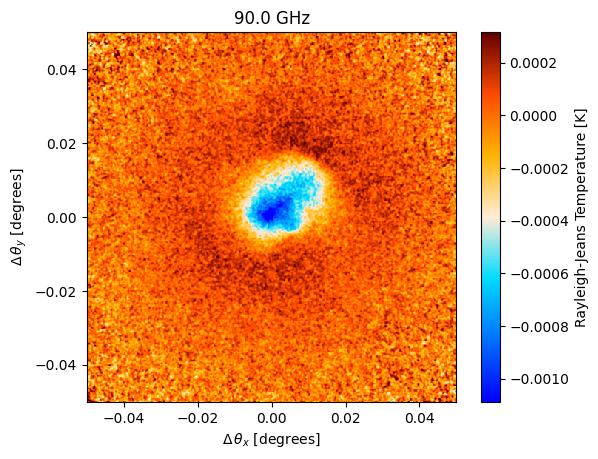

In [35]:
output_map.plot()

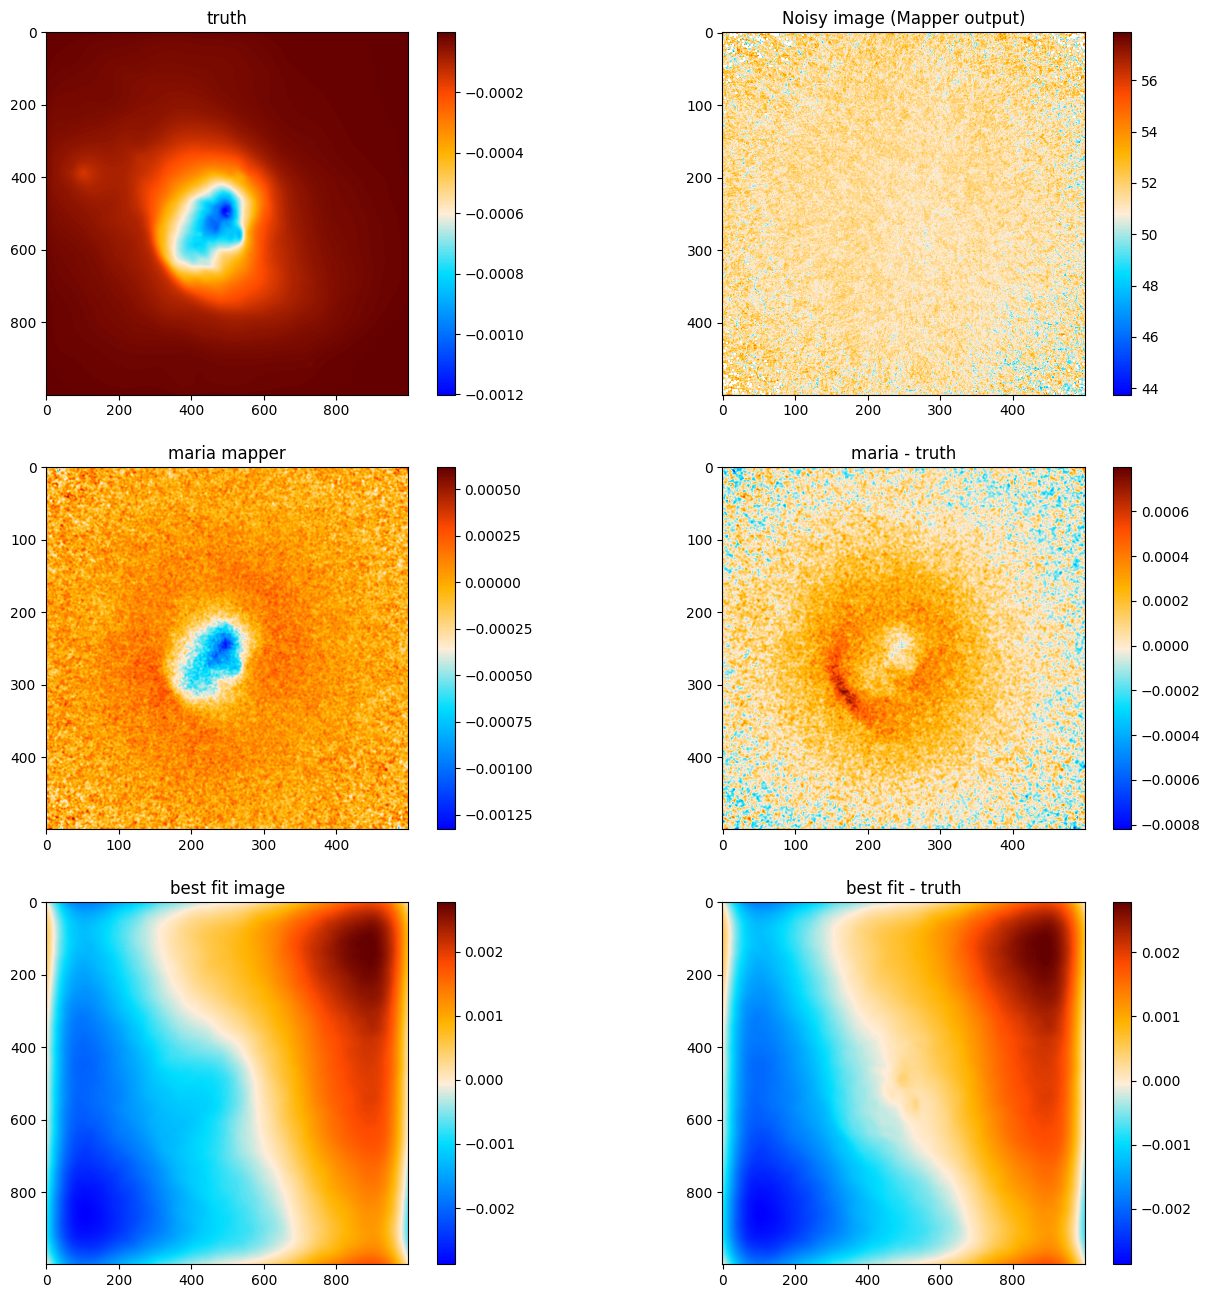

In [36]:
from skimage.transform import resize

# Compare nifty vs maria
# sig_map = gp_map(samples.pos)[padding_map//2:-padding_map//2, padding_map//2:-padding_map//2] # when splitting up in different field models
sig_map = gp_map(samples.pos)
# mincol = -0.0012
# maxcol = 0.
mincol = None
maxcol = None

cmb_cmap = plt.get_cmap('cmb')
fig, axes = plt.subplots(3, 2, figsize=(16, 16))

im0 = axes[0,0].imshow( mapdata_truth[0] , cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[0,0].title.set_text('truth')
fig.colorbar(im0)

im1 = axes[0,1].imshow(output_truthmap.data[0], cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
fig.colorbar(im1)
axes[0,1].title.set_text("Noisy image (Mapper output)")

im2 = axes[1,0].imshow(output_map.data[0], cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[1,0].title.set_text('maria mapper')
fig.colorbar(im2)

truth_rescaled = resize(mapdata_truth[0], (500, 500), anti_aliasing=True)
im3 = axes[1,1].imshow((output_map.data[0] - truth_rescaled), cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[1,1].title.set_text('maria - truth')
fig.colorbar(im3)

im3 = axes[2,0].imshow(sig_map, cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[2,0].title.set_text('best fit image')
fig.colorbar(im3)

im4 = axes[2,1].imshow((sig_map - mapdata_truth[0]), cmap=cmb_cmap, vmin=mincol, vmax=maxcol)
axes[2,1].title.set_text('best fit - truth')
fig.colorbar(im4)

plt.show()